In [1]:
import pandas as pd
import math
import random
import numpy as np

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklego.metrics import equal_opportunity_score
from sklego.metrics import p_percent_score
from sklearn.metrics import log_loss, accuracy_score
from sklearn.utils.extmath import squared_norm
import optuna, sklearn, sklearn.datasets

from sklego.linear_model import DemographicParityClassifier
from sklego.linear_model import EqualOpportunityClassifier
from sklearn.linear_model import LogisticRegression

from moopt.scalarization_interface import scalar_interface, single_interface, w_interface
from moopt import monise

from fair_models import coefficient_of_variation, MOOLogisticRegression, FindCLogisticRegression, FindCCLogisticRegression
from fair_models import calc_reweight
from fair_models import FairScalarization, EqualScalarization
from fair_models import SimpleVoting

import plotly
import plotly.graph_objects as go
import matplotlib.pyplot as plt

import sys
sys.path.append("./MMFP/")
from MMPF.MinimaxParetoFair.MMPF_trainer import SKLearn_Weighted_LLR, APSTAR

In [2]:
def evaluate_model_test(model__):
    metrics_value = {}

    metrics_value["Acc"] = accuracy_score(y_test, model__.predict(X_test))
    metrics_value["EO"] = equal_opportunity_score(sensitive_column=fair_feature)(model__, X_test, y_test)
    metrics_value["DP"] = p_percent_score(sensitive_column=fair_feature)(model__,X_test)
    metrics_value["CV"] = coefficient_of_variation(model__, X_test, y_test)

    print("Accuracy: ", metrics_value["Acc"])
    print("Equal Opportunity: ", metrics_value["EO"])
    print("Demographic Parity: ", metrics_value["DP"])
    print("Coefficient of Variation: ", metrics_value["CV"])

    return metrics_value

In [3]:
hist_color = {'Minimax': '#a65628', 'LogReg':'#f781bf', 'Reweight':'#4daf4a', 
                'ParDem': '#984ea3', 'EqOp': '#ff7f00', 'MOOErro': '#377eb8','MOOAcep': '#e41a1c'}
line_color = {'Minimax': '#c9997e', 'LogReg':'#f781bf', 'Reweight':'#94cf92', 
                'ParDem': '#c194c7', 'EqOp': '#ffb266', 'MOOErro': '#87b1d4','MOOAcep': '#f18c8d'}

# 1) Dataset

In [4]:
data = pd.read_csv("Datasets - Limpos/compas_onerace.csv")
fair_feature = "not_white"
pred_feature = "Two_yr_Recidivism"

In [5]:
categories_fair_class = []

for index, row in data.iterrows():
    if row[pred_feature] == -1:
        categories_fair_class.append(row[fair_feature])
    else:
        categories_fair_class.append(row[fair_feature]+2)

random_gen = random.randint(0, 1000)
print("Random state: ", random_gen)

X = data.drop([pred_feature], axis=1)
y = data[pred_feature]

X_tv, X_test, y_tv, y_test = train_test_split(X, y, test_size=int(data.shape[0]*0.2),stratify=categories_fair_class,
                                             random_state=random_gen)

ads = [categories_fair_class[i] for i in range(data.shape[0]) if i in X_tv.index.tolist()]
X_train, X_val, y_train, y_val = train_test_split(X_tv, y_tv, test_size=int(data.shape[0]*0.2),
                                                  stratify=ads, random_state=random_gen)

Random state:  861


# 2) Test approaches

In [6]:
models_metrics = []

## 2.1) Logistic Regression

In [7]:
# Train
logreg_model = LogisticRegression().fit(X_train, y_train)

# Evaluate
logreg_metrics = evaluate_model_test(logreg_model)

# Save values
logreg_metrics['Approach'] = 'LogReg'
models_metrics.append(logreg_metrics)

Accuracy:  0.6750405186385737
Equal Opportunity:  0.6336571825121443
Demographic Parity:  0.5818428602276582
Coefficient of Variation:  0.8449046510875114


## 2.2) Reweighting

In [8]:
# Train
sample_weight = calc_reweight(X_train, y_train, fair_feature)
reweigh_model = LogisticRegression().fit(X_train, y_train,sample_weight=sample_weight)

# Evaluate
reweigh_metrics = evaluate_model_test(reweigh_model)

# Save values
reweigh_metrics['Approach'] = 'Reweigh'
models_metrics.append(reweigh_metrics)

Accuracy:  0.6701782820097245
Equal Opportunity:  0.8377377008955956
Demographic Parity:  0.8253095184384082
Coefficient of Variation:  0.8450016349041191


## 2.3) MiniMax

- Paper: http://proceedings.mlr.press/v119/martinez20a.html
- Code: https://github.com/natalialmg/MMPF

In [9]:
# Train
a_train = X_train[fair_feature].copy().astype('int')
a_val = X_val[fair_feature].copy().astype('int')

a_train[a_train==0] = -1
a_val[a_val==0] = -1

minimax_model = SKLearn_Weighted_LLR(X_train.values, y_train.values,
                a_train.values, X_val.values,
                y_val.values, a_val.values)

mua_ini = np.ones(a_val.max() + 1)
mua_ini /= mua_ini.sum()
results = APSTAR(minimax_model, mua_ini, niter=200, max_patience=200, Kini=1,
                        Kmin=20, alpha=0.5, verbose=False)
mu_best_list = results['mu_best_list']

mu_best = mu_best_list[-1]
minimax_model.weighted_fit(X_train.values, y_train.values, a_train.values, mu_best)

# Evaluate
minimax_metrics = evaluate_model_test(minimax_model)

# Save values
minimax_metrics['Approach'] = 'Minimax'
models_metrics.append(minimax_metrics)

patience counter: 199 total iterations: 201
-----------------------------------------
Accuracy:  0.6742301458670988
Equal Opportunity:  0.6268663647973992
Demographic Parity:  0.5798391247992162
Coefficient of Variation:  0.8478115506709567


## 2.4) Demographic Parity Classifier

- Paper: https://arxiv.org/pdf/1610.02413.pdf
- Code: https://github.com/mbilalzafar/fair-classification/tree/master/disparate_impact 

They use covariance_threshold = 0 in the code

In [10]:
# Train
dempar_model = DemographicParityClassifier(sensitive_cols=fair_feature, covariance_threshold=0)
dempar_model.fit(X_train, y_train)

# Evaluate
dempar_metrics = evaluate_model_test(dempar_model)

# Save values
dempar_metrics['Approach'] = 'DemPar'
models_metrics.append(dempar_metrics)

Accuracy:  0.5632090761750406
Equal Opportunity:  0.5585497835497835
Demographic Parity:  0.7098157539962766
Coefficient of Variation:  1.1539192275188463


## 2.5) Equality of Opportunity Classifier

- Paper: https://arxiv.org/pdf/1610.02413.pdf
- Code: https://github.com/mbilalzafar/fair-classification/tree/master/disparate_impact 

They use covariance_threshold = 0 in the code

In [11]:
# Train
eqop_model = EqualOpportunityClassifier(sensitive_cols=fair_feature, positive_target=True, covariance_threshold=0)
eqop_model.fit(X_train, y_train)

# Evaluate
eqop_metrics = evaluate_model_test(eqop_model)

# Save values
eqop_metrics['Approach'] = 'EqOp'
models_metrics.append(eqop_metrics)

Accuracy:  0.5899513776337115
Equal Opportunity:  0.2372172428510457
Demographic Parity:  0.21456848772763262
Coefficient of Variation:  1.1743497883655618


## 2.6) MOOError

In [12]:
# Train
## Train 150 models
moo_err = monise(weightedScalar=FairScalarization(X_train, y_train, fair_feature),
                 singleScalar=FairScalarization(X_train, y_train, fair_feature),
                  nodeTimeLimit=2, targetSize=150,
                  targetGap=0, nodeGap=0.05, norm=False)

moo_err.optimize()

## Evaluate the models in val
mooerr_values = {"Acc": [], "EO": [], "DP": [], "CV": []}
mooerr_sols = []

for solution in moo_err.solutionsList:
    mooerr_sols.append(solution.x)
    mooerr_values["Acc"].append(solution.x.score(X_val, y_val))
    mooerr_values["EO"].append(equal_opportunity_score(sensitive_column=fair_feature)(solution.x, X_val, y_val))
    mooerr_values["DP"].append(p_percent_score(sensitive_column=fair_feature)(solution.x,X_val))
    mooerr_values["CV"].append(coefficient_of_variation(solution.x, X_val, y_val))

mooerr_df = pd.DataFrame(mooerr_values)

## Filter the 20 best models in Acc, then the 10 best in EO
index_list = list(mooerr_df.nlargest(20,'Acc').nlargest(10,'EO').index)
mooerr_filtered_models = [("Model "+str(i), mooerr_sols[i]) for i in index_list]

## Generate ensemble
ensemble_moo_err = SimpleVoting(estimators=mooerr_filtered_models, voting='soft', minimax=False)

2021-06-30 22:34:17,148 - moopt.monise - DEBUG: Finding 1th individual minima
2021-06-30 22:34:17,193 - moopt.monise - DEBUG: Finding 2th individual minima
2021-06-30 22:34:17,228 - moopt.monise - DEBUG: Finding 3th individual minima
Academic license - for non-commercial use only - expires 2021-08-27
Using license file /Users/vitoriaguardieiro/gurobi.lic
2021-06-30 22:34:17,356 - moopt.monise - DEBUG: 4th solution - importance: 1.0
2021-06-30 22:34:17,423 - moopt.monise - DEBUG: 5th solution - importance: 1.0
2021-06-30 22:34:17,467 - moopt.monise - DEBUG: 6th solution - importance: 1.0
2021-06-30 22:34:17,521 - moopt.monise - DEBUG: 7th solution - importance: 1.0
2021-06-30 22:34:17,601 - moopt.monise - DEBUG: 8th solution - importance: 1.0
2021-06-30 22:34:17,680 - moopt.monise - DEBUG: 9th solution - importance: 0.32328169688587893
2021-06-30 22:34:17,742 - moopt.monise - DEBUG: 10th solution - importance: 0.2889321993723431
2021-06-30 22:34:17,809 - moopt.monise - DEBUG: 11th solut

In [13]:
# Evaluate
mooerr_metrics = evaluate_model_test(ensemble_moo_err)
mooerr_metrics['Approach'] = 'MOOErr'

# Save values
models_metrics.append(mooerr_metrics)

Accuracy:  0.673419773095624
Equal Opportunity:  0.8082134082134081
Demographic Parity:  0.756311901912021
Coefficient of Variation:  0.8269333738413547


## 2.7) MOOAcep

In [63]:
# Train 150 models
mooacep = monise(weightedScalar=EqualScalarization(X_train, y_train, fair_feature),
             singleScalar=EqualScalarization(X_train, y_train, fair_feature),
              nodeTimeLimit=2, targetSize=150,
              targetGap=0, nodeGap=0.01, norm=False)

mooacep.optimize()

# Evaluate the models
mooacep_values_val = {"Acc": [], "EO": [], "DP": [], "CV": []}
mooacep_sols = []

for solution in mooacep.solutionsList:
    mooacep_sols.append(solution.x)
    mooacep_values_val["Acc"].append(solution.x.score(X_val, y_val))
    mooacep_values_val["EO"].append(equal_opportunity_score(sensitive_column=fair_feature)(solution.x, X_val, y_val))
    mooacep_values_val["DP"].append(p_percent_score(sensitive_column=fair_feature)(solution.x,X_val))
    mooacep_values_val["CV"].append(coefficient_of_variation(solution.x, X_val, y_val))

mooacep_df = pd.DataFrame(mooacep_values_val)

## Filter the 20 best models in Acc, then the 10 best in EO
index_list = list(mooacep_df.nlargest(20,'Acc').nlargest(10,'EO').index)
mooacep_filtered_models = [("Model "+str(i), mooacep_sols[i]) for i in index_list]

## Generate ensemble
ensemble_mooacep = SimpleVoting(estimators=mooacep_filtered_models, voting='soft', minimax=False)

2021-06-30 22:27:35,013 - moopt.monise - DEBUG: Finding 1th individual minima
2021-06-30 22:27:35,124 - moopt.monise - DEBUG: Finding 2th individual minima
2021-06-30 22:27:35,170 - moopt.monise - DEBUG: Finding 3th individual minima
2021-06-30 22:27:35,215 - moopt.monise - DEBUG: Finding 4th individual minima
2021-06-30 22:27:35,375 - moopt.monise - DEBUG: 5th solution - importance: 1.0
2021-06-30 22:27:35,492 - moopt.monise - DEBUG: 6th solution - importance: 1.0
2021-06-30 22:27:35,610 - moopt.monise - DEBUG: 7th solution - importance: 1.0
2021-06-30 22:27:35,768 - moopt.monise - DEBUG: 8th solution - importance: 1.0
2021-06-30 22:27:35,875 - moopt.monise - DEBUG: 9th solution - importance: 1.0
2021-06-30 22:27:35,933 - moopt.monise - DEBUG: 10th solution - importance: 0.7071361360132049
2021-06-30 22:27:36,041 - moopt.monise - DEBUG: 11th solution - importance: 0.6070399589861305
2021-06-30 22:27:36,132 - moopt.monise - DEBUG: 12th solution - importance: 0.4893338140782418
2021-06-

In [64]:
# Evaluate
mooacep_metrics = evaluate_model_test(ensemble_mooacep)
mooacep_metrics['Approach'] = 'MOOAcep'

# Save values
models_metrics.append(mooacep_metrics)

Accuracy:  0.640194489465154
Equal Opportunity:  0.9402485857042574
Demographic Parity:  0.8809387297060222
Coefficient of Variation:  0.7658270585949999


## 2.8) Results

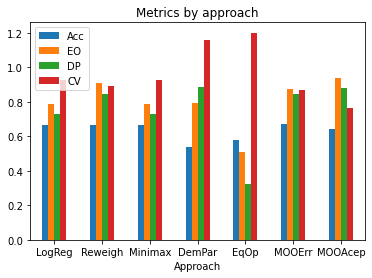

In [65]:
metrics_df = pd.DataFrame(models_metrics)
metrics_df = metrics_df.set_index('Approach')

metrics_df.plot.bar(rot=0)
plt.title('Metrics by approach')
plt.show()

In [66]:
metrics_df

,Acc,EO,DP,CV
Approach,,,,
LogReg,0.663695,0.790050,0.728464,0.926639
Reweigh,0.664506,0.909203,0.845249,0.889778
Minimax,0.664506,0.790050,0.731065,0.925987
DemPar,0.539708,0.794662,0.888396,1.159748
EqOp,0.580227,0.511928,0.321853,1.201122
MOOErr,0.673420,0.875890,0.845613,0.869975
MOOAcep,0.640194,0.940249,0.880939,0.765827
